# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Чтобы учесть все требования, построим разные модели и сравним их по указанным характеристикам.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Подготовка-выборок" data-toc-modified-id="Подготовка-выборок-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка выборок</a></span><ul class="toc-item"><li><span><a href="#Для-LinearRegression" data-toc-modified-id="Для-LinearRegression-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Для LinearRegression</a></span></li><li><span><a href="#Для-CatBoostRegressor-и-LGBMRegressor" data-toc-modified-id="Для-CatBoostRegressor-и-LGBMRegressor-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Для CatBoostRegressor и LGBMRegressor</a></span></li><li><span><a href="#Для-DecisionTreeRegressor" data-toc-modified-id="Для-DecisionTreeRegressor-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Для DecisionTreeRegressor</a></span></li></ul></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

## Подготовка данных

### Обзор данных

Импортируем бибилиотеки и определим константы:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

SEED = 42

Считаем и сохраним датасет в переменную:

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

Выведем на экран первые, последние и случайные пять строк таблицы, а также общую информацию. Создадим для этого собственную функцию:

In [3]:
def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=seed),
                              df.tail(n_rows)
                             ]))

total_view(df)
display(df.describe().T)
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
261189,2016-03-31 13:50:34,699,wagon,1999,manual,136,astra,150000,4,petrol,opel,yes,2016-03-31 00:00:00,0,40883,2016-03-31 13:50:34
201687,2016-03-11 16:45:36,520,NaN,2000,NaN,106,NaN,20000,0,NaN,opel,no,2016-03-11 00:00:00,0,26388,2016-03-21 03:18:31
13209,2016-03-29 13:49:45,900,small,1998,NaN,101,a3,150000,0,petrol,audi,yes,2016-03-29 00:00:00,0,49626,2016-03-29 13:49:45
252127,2016-03-22 11:51:50,1650,sedan,1998,manual,101,golf,150000,3,petrol,volkswagen,no,2016-03-22 00:00:00,0,14513,2016-03-25 03:18:42
222669,2016-03-22 13:45:10,1600,small,2001,manual,75,2_reihe,150000,3,petrol,peugeot,no,2016-03-22 00:00:00,0,26345,2016-03-23 21:15:16


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
cond = 'VehicleType.isna() or Gearbox.isna() or Model.isna() or FuelType.isna() or NotRepaired.isna()'
print(f'Пропущенные значения: {round((df.query(cond, engine="python").shape[0] / df.shape[0]) * 100, 2)}%')

Пропущенные значения: 30.63%


В датасете 16 колонок и 354369 строк. Типы данных в колонках `object` и `int64`. Тип данных `object` не соответствует содержащемуся в колонках `DateCrawled`, `DateCreated`, `LastSeen`  типу данных (дата и время).

Согласно документации к данным, к признаками относятся следующие колонки:
* `DateCrawled` — дата скачивания анкеты из базы;
* `VehicleType` — тип автомобильного кузова;
* `RegistrationYear` — год регистрации автомобиля;
* `Gearbox` — тип коробки передач;
* `Power` — мощность (л. с.);
* `Model` — модель автомобиля;
* `Kilometer` — пробег (км);
* `RegistrationMonth` — месяц регистрации автомобиля;
* `FuelType` — тип топлива;
* `Brand` — марка автомобиля;
* `NotRepaired` — была машина в ремонте или нет;
* `DateCreated` — дата создания анкеты;
* `NumberOfPictures` — количество фотографий автомобиля;
* `PostalCode` — почтовый индекс владельца анкеты (пользователя);
* `LastSeen` — дата последней активности пользователя.

Целевой признак:
* `Price` — цена (евро).

В данных присутствуют пропущенные значения (колонки `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`) - примерно 31% записей с пропусками.

В колонке `Price` присутствуют нулевые значения - это могут быть пропуски или машины в очень плохом состоянии. В `RegistrationYear` самый ранний год регистрации - 1000, самый поздний - 9999. В `Power` - минимальная мощность составляет 0 л.с., максимальная - 20000. В `RegistrationMonth` есть нулевой месяц регистрации. Требования к формату почтового индекса не известны, будем считать, что в этой колонке ошибок нет. `Kilometer` также не вызывает вопросов.

Кроме того, среди признаков есть неинформативные  - даты действий с анкетой/активности пользователя, в колонке `NumberOfPictures` только нулевые значения.

**Выводы:**
- в каждой строке датасета содержатся данные о состоянии автомобиля, его технические характеристики, даты действий с анкетой и активности пользователя;
- в данных много пропущенных значений - примерно 31% датасета;
- присутствуют артефакты: 
  - в `Price` присутствуют нулевые значения;
  - в `RegistrationYear` самый ранний год регистрации - 1000, самый поздний - 9999;
  - в `Power` - минимальная мощность составляет 0 л.с., максимальная - 20000;
  - в `RegistrationMonth` есть нулевой месяц регистрации.
- также необходимо проверить датасет на дубликаты, а колонки с категориальными строковыми данными на неявные дубликаты.

### Предобработка данных

Посмотрим на уникальные значения в колонках:

In [6]:
object_list = ['VehicleType', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired']
for column in object_list:
    print(column, df[column].unique())
    print()

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Gearbox ['manual' 'auto' nan]

Model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuor

Неявные дубликаты отсутствуют. Месяц регистрации 0 скорее всего не был указан при заполнении анкеты, восстановить номер месяца невозможно, а если удалить, то потеряем слишком много данных, поэтому оставим как есть.

Посмотрим на распределение года регистрации автомобиля:

527

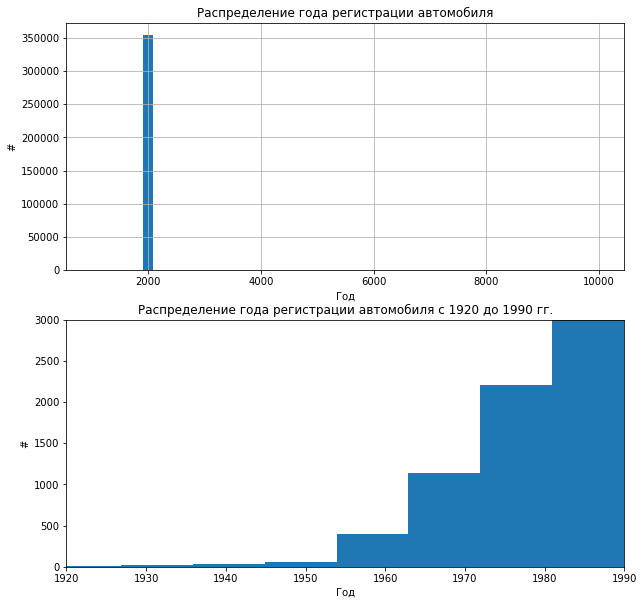

In [7]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
df['RegistrationYear'].hist(bins=50)
plt.title('Распределение года регистрации автомобиля')
plt.xlabel('Год')
plt.ylabel('#')

plt.subplot(2, 1, 2)
df['RegistrationYear'].plot.hist(bins=1000, xlim=(1920, 1990), ylim=(0, 3000))
plt.title('Распределение года регистрации автомобиля c 1920 до 1990 гг.')
plt.xlabel('Год')
plt.ylabel('#')

df[(df['RegistrationYear'] < 1960) | (df['RegistrationYear'] > 2022)]['RegistrationYear'].count()

Количество автомобилей с годом регистрации до 1960 г. и после 2022 г. незначительное. Удалим их:

In [8]:
df = df.loc[(df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2022)]

Посмотрим на распределение мощности автомобилей:

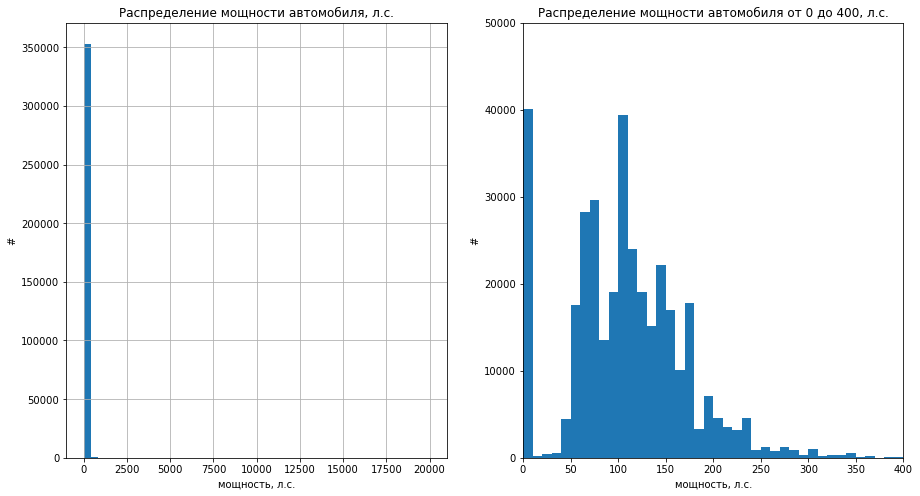

In [9]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
df['Power'].hist(bins=50)
plt.title('Распределение мощности автомобиля, л.с.')
plt.xlabel('мощность, л.с.')
plt.ylabel('#')

plt.subplot(1, 2, 2)
df['Power'].plot.hist(bins=2000, xlim=(0, 400), ylim=(0, 50000))
plt.title('Распределение мощности автомобиля от 0 до 400, л.с.')
plt.xlabel('мощность, л.с.')
plt.ylabel('#');

На графике видно, что присутствует довольно много нулевых значений, их можно заменить медианой по соответствующей модели в `Model`. Выбросы справа ограничим по квантилю:

In [10]:
df = df[df['Power'] < df['Power'].quantile(0.995)]

Пропущенные значения в колонках `VehicleType`, `Gearbox`, `FuelType` будем заменять модой по соответствующей модели в `Model`, в `Power` - медианой. Чтобы данные при этом не сильно исказились - пропуски в `Model` заполним значением 'unknown', только в тех строках, которые не совпадают с пропусками в перечисленных колонках, а остальное удалим:

In [11]:
df = df.loc[~((df['Model'].isna()) & ((df['VehicleType'].isna()) 
                                    | (df['Gearbox'].isna()) 
                                    | (df['FuelType'].isna()) 
                                    | (df['Power'] == 0)))].fillna({'Model': 'unknown'})

In [12]:
def make_dict(col_name):
    '''Возвращает словарь с названием модели и ее модой из указанной колонки'''
    return dict(df.groupby('Model')[col_name].agg(lambda x: pd.Series.mode(x)[0]))

def fillnawithmode(row):
    '''Возвращает значение из словаря по указанному ключу'''
    value = dictionary[row]
    return value

In [13]:
# заполнение пропусков в 'VehicleType', 'Gearbox', 'FuelType'
columns = ['VehicleType', 'Gearbox', 'FuelType']
for column in columns:
    dictionary = make_dict(column)
    condition = df[column].isna()
    df.loc[condition, column] = df.loc[condition, 'Model'].apply(fillnawithmode)
    
# заполнение пропусков в 'Power'
df.loc[df['Power'] == 0, 'Power'] = np.NaN
df['Power'] = df.groupby('Model')['Power'].apply(lambda x: x.fillna(x.median()))
# удалим оставшиеся 2 пропуска
df = df[df['Power'].notna()]

В колонке `Price` есть нулевые значения - скорее всего продавец не указал цену при заполнении анкеты. Удалим эти строки:

In [14]:
df = df[df['Price'] != 0]

In [15]:
df.groupby('NotRepaired', dropna=False)['Price'].agg(Median_price = 'median')

,Median_price
NotRepaired,
no,3790.0
yes,1000.0
NaN,1599.0


В колонке `NotRepaired` довольно много пропущенных значений. По медианной цене они находятся ближе к 'битым' - заполним пропуски значением 'yes':

In [16]:
df['NotRepaired'] = df['NotRepaired'].fillna('yes')
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Все пропуски обработаны. Проверим данные на дубликаты:

In [17]:
df.duplicated().sum()

4

In [18]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Дубликаты удалены. Теперь удалим неинформативные признаки и посмотрим что в итоге получилось. Почтовый индекс оставим - стоимость автомобиля в разных регионах может отличаться:

In [19]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen'], axis=1)

In [20]:
total_view(df)
df.shape

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,sedan,1993,manual,101.0,golf,150000,0,petrol,volkswagen,yes,70435
1,18300,coupe,2011,manual,190.0,unknown,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,yes,90480
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,60437
13146,1450,small,2000,manual,75.0,2_reihe,150000,10,petrol,peugeot,no,72661
6528,8300,small,2014,auto,71.0,fortwo,20000,3,petrol,smart,no,97082
170691,1400,convertible,1994,auto,101.0,golf,150000,4,petrol,volkswagen,no,97318
180865,7700,bus,2007,manual,105.0,transporter,90000,6,gasoline,volkswagen,no,38644
288541,3500,sedan,1998,auto,170.0,5er,150000,8,petrol,bmw,no,66115


(331622, 12)

Построим матрицу корреляции количественных признаков:

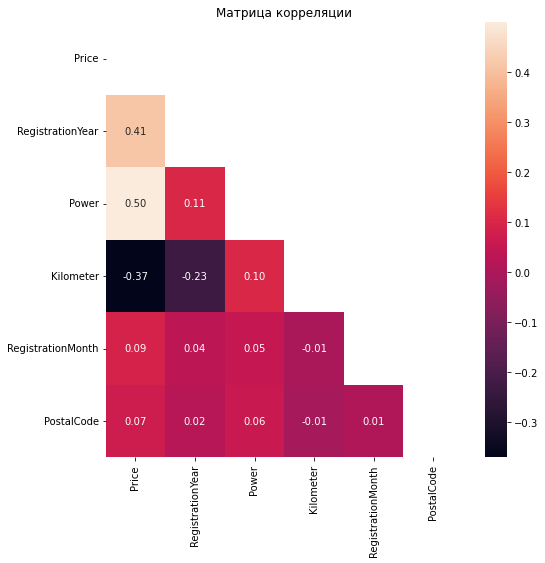

In [21]:
plt.figure(figsize=(8,8))
plt.title('Матрица корреляции')
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=matrix);

Сильнее всего с ценой коррелируют мощность (коэффициент Пирсона 0.5), год регистрации (0.41) и пробег (-0.37) - чем выше мощность, позже год регистрации и меньше пробег - тем выше цена.

**Выводы:**

В ходе предобработки данных было:
- удалено примерно 6.4% данных;
- пропущенные значения в `VehicleType`, `Gearbox`, `FuelType` заполнены модой по соответствующей модели в `Model`;
- нулевые значения в `Power` заполнены медианой по соответствующей модели в `Model`;
- пропуски в `NotRepaired` заполнены значением 'yes';
- удалены колонки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen` как неинформативные;
- устранены дубликаты;
- невяные дубликаты не выявлены.

### Подготовка выборок

#### Для LinearRegression

Удалим колонку `PostalCode`, так как она содержит слишком много уникальных значений. Преобразуем категориальные признаки в численные с помощью техники OHE:

In [22]:
df_ohe = df.copy()
df_ohe = df_ohe.drop('PostalCode', axis=1)
df_ohe = pd.get_dummies(df_ohe, drop_first=True)
total_view(df_ohe)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,480,1993,101.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,18300,2011,190.0,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1500,2001,75.0,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69.0,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
6496,750,1996,70.0,150000,6,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
170737,350,1998,60.0,150000,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
317878,2450,2004,102.0,125000,3,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
190634,15500,2011,105.0,50000,5,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
169362,1200,1996,90.0,150000,10,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Разделим данные на обучающую и тестовую выборки:

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df_ohe.drop('Price', axis=1),
                                                    df_ohe['Price'],
                                                    test_size=0.20,
                                                    random_state=SEED)

print('x_train:',x_train.shape, '\n',
      'y_train:', y_train.shape, '\n',
      'x_test:', x_test.shape, '\n',
      'y_test:', y_test.shape)

x_train: (265297, 307) 
 y_train: (265297,) 
 x_test: (66325, 307) 
 y_test: (66325,)


Данные разделены на выборки следующим образом: обучающая - 80%, тестовая - 20%.

Проведем масштабирование численных признаков:

In [24]:
pd.options.mode.chained_assignment = None

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

total_view(x_train)
total_view(x_test)

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
222588,-1.032424,-0.862245,0.578584,-1.595279,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
78874,0.398229,-1.063169,0.578584,-0.503503,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
310776,-0.603228,-0.038453,0.578584,-0.503503,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
121110,-1.175489,-0.862245,0.578584,1.407106,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
278372,0.684360,0.443766,0.578584,-1.322335,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
133864,-1.890815,0.283026,0.578584,0.315330,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
349391,0.255164,-0.038453,0.578584,-0.230559,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
101837,-4.465990,-1.485111,-1.581701,-1.595279,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
122984,-0.460163,-1.163632,0.578584,-0.776447,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
314112,1.256621,-0.641227,-2.661844,-0.503503,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
198336,-0.460163,0.262934,0.578584,-1.595279,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
280173,-0.317097,1.488575,-0.771594,-0.503503,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189117,0.112099,-1.545389,-1.581701,0.315330,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
57671,0.398229,1.187188,0.578584,0.042386,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
143390,-0.460163,0.001732,0.578584,-1.049391,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297099,-0.030967,4.321613,0.578584,1.680050,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
162778,0.255164,2.955325,0.578584,1.134162,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
131930,-0.746293,-0.159008,0.578584,0.042386,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
211118,1.542751,-0.982799,-2.661844,0.315330,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30622,2.115012,-1.465019,0.578584,-0.503503,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1


#### Для CatBoostRegressor и LGBMRegressor

In [25]:
df_cb = df.copy()

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']
df_cb[cat_features] = df_cb[cat_features].astype('category')
x_train_cb, x_test_cb, y_train_cb, y_test_cb = train_test_split(df_cb.drop('Price', axis=1),
                                                                df_cb['Price'],
                                                                test_size=0.20,
                                                                random_state=SEED)

print('x_train_cb:',x_train_cb.shape, '\n',
      'y_train_cb:', y_train_cb.shape, '\n',
      'x_test_cb:', x_test_cb.shape, '\n',
      'y_test_cb:', y_test_cb.shape)

total_view(x_train_cb)
total_view(x_test_cb)

x_train_cb: (265297, 11) 
 y_train_cb: (265297,) 
 x_test_cb: (66325, 11) 
 y_test_cb: (66325,)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
222588,sedan,1996,manual,75.0,golf,150000,0,petrol,volkswagen,no,49565
78874,small,2006,manual,65.0,clio,150000,4,petrol,renault,yes,46049
310776,sedan,1999,manual,116.0,vectra,150000,4,petrol,opel,no,65232
121110,wagon,1995,manual,75.0,golf,150000,11,petrol,volkswagen,no,44147
278372,wagon,2008,manual,140.0,passat,150000,1,gasoline,volkswagen,no,66740
201773,sedan,1992,manual,90.0,golf,150000,9,petrol,volkswagen,no,84028
203888,wagon,1980,auto,130.0,other,150000,12,petrol,opel,no,13086
3990,wagon,2007,manual,105.0,passat,150000,10,gasoline,volkswagen,no,48703
158469,wagon,2002,manual,115.0,focus,150000,0,gasoline,ford,no,95028
261233,sedan,1999,manual,101.0,a3,150000,3,petrol,audi,no,66892


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
198336,wagon,2000,manual,131.0,passat,150000,0,gasoline,volkswagen,yes,74635
280173,convertible,2001,manual,192.0,3er,100000,4,petrol,bmw,no,52222
189117,small,2004,auto,41.0,fortwo,70000,7,gasoline,smart,no,76831
57671,suv,2006,manual,177.0,rav,150000,6,gasoline,toyota,no,70376
143390,wagon,2000,manual,118.0,unknown,150000,2,petrol,bmw,no,17489
240921,convertible,2002,manual,150.0,other,150000,11,petrol,saab,no,53343
143674,small,2004,manual,54.0,polo,125000,1,petrol,volkswagen,no,6112
182843,bus,1993,manual,110.0,transporter,150000,5,petrol,volkswagen,no,82515
233116,small,1999,manual,54.0,other,70000,5,petrol,hyundai,no,44651
196108,bus,2010,manual,125.0,altea,70000,7,petrol,seat,yes,45257


#### Для DecisionTreeRegressor

In [26]:
df_dt = df.copy()

encoder = OrdinalEncoder()
df_dt[cat_features] = encoder.fit_transform(df_dt[cat_features])

x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(df_dt.drop('Price', axis=1),
                                                                        df_dt['Price'],
                                                                        test_size=0.20,
                                                                        random_state=SEED)

print('x_train_dt:',x_train_dt.shape, '\n',
      'y_train_dt:', y_train_dt.shape, '\n',
      'x_test_dt:', x_test_dt.shape, '\n',
      'y_test_dt:', y_test_dt.shape)

total_view(x_train_dt)
total_view(x_test_dt)

x_train_dt: (265297, 11) 
 y_train_dt: (265297,) 
 x_test_dt: (66325, 11) 
 y_test_dt: (66325,)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
222588,4.0,1996,1.0,75.0,116.0,150000,0,6.0,38.0,0.0,3425.0
78874,5.0,2006,1.0,65.0,75.0,150000,4,6.0,27.0,1.0,3205.0
310776,4.0,1999,1.0,116.0,234.0,150000,4,6.0,24.0,0.0,4435.0
121110,7.0,1995,1.0,75.0,116.0,150000,11,6.0,38.0,0.0,3073.0
278372,7.0,2008,1.0,140.0,170.0,150000,1,2.0,38.0,0.0,4571.0
162693,4.0,2008,1.0,136.0,58.0,100000,4,2.0,5.0,0.0,2193.0
214004,5.0,1997,1.0,60.0,226.0,150000,8,6.0,27.0,1.0,3884.0
262,7.0,2007,1.0,140.0,170.0,150000,11,2.0,38.0,0.0,7391.0
336373,4.0,1997,1.0,86.0,138.0,90000,6,6.0,7.0,0.0,571.0
11002,4.0,2008,1.0,143.0,6.0,70000,8,6.0,2.0,0.0,3344.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
198336,7.0,2000,1.0,131.0,170.0,150000,0,2.0,38.0,1.0,5334.0
280173,1.0,2001,1.0,192.0,11.0,100000,4,6.0,2.0,0.0,3578.0
189117,5.0,2004,0.0,41.0,106.0,70000,7,2.0,32.0,0.0,5517.0
57671,6.0,2006,1.0,177.0,186.0,150000,6,2.0,36.0,0.0,4886.0
143390,7.0,2000,1.0,118.0,227.0,150000,2,6.0,2.0,0.0,1044.0
348591,4.0,1989,0.0,211.0,15.0,150000,9,6.0,2.0,0.0,4828.0
279076,5.0,2007,1.0,73.0,8.0,150000,10,6.0,25.0,0.0,2505.0
76279,4.0,1997,1.0,88.0,10.0,80000,3,6.0,19.0,0.0,3033.0
85920,5.0,2013,1.0,82.0,209.0,20000,6,6.0,3.0,0.0,4202.0
85039,1.0,2011,1.0,156.0,8.0,70000,4,6.0,25.0,0.0,4151.0


Выборки подготовлены, можно переходить к обучению моделей.

## Обучение моделей

### LinearRegression

In [27]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
scores_lr = cross_val_score(model_lr, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print('Средняя оценка качества модели (rmse):', -1 * np.mean(scores_lr))

Средняя оценка качества модели (rmse): 2679.6461910499143


### DecisionTreeRegressor

In [28]:
model_dt = DecisionTreeRegressor(random_state=SEED)
param_grid = {'max_depth': range(9, 15)}
grid = GridSearchCV(model_dt, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(x_train_dt, y_train_dt)

print(f'Средняя оценка качества модели (rmse): {-1 * grid.best_score_}',
      f'Наилучшие параметры, max_depth: {grid.best_params_["max_depth"]}',
      sep='\n')

Средняя оценка качества модели (rmse): 1972.7002132122902
Наилучшие параметры, max_depth: 13


### LGBMRegressor

In [29]:
model_lgbm = LGBMRegressor(random_state=SEED, metric='rmse')
param_grid = {'max_depth': [8, 9, 10, 11],
              'n_estimators': [140, 180, 200, 220],
              'learning_rate': [0.1, 0.2, 0.3]
              }
grid = GridSearchCV(model_lgbm, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid.fit(x_train_cb, y_train_cb)

print(f'Средняя оценка качества модели (rmse): {-1 * grid.best_score_}',
      'Наилучшие параметры:',
      f'max_depth: {grid.best_params_["max_depth"]}',
      f'n_estimators: {grid.best_params_["n_estimators"]}',
      f'learning_rate: {grid.best_params_["learning_rate"]}',
      sep='\n')

Средняя оценка качества модели (rmse): 1654.5446669083162
Наилучшие параметры:
max_depth: 11
n_estimators: 220
learning_rate: 0.1


### CatBoostRegressor

In [30]:
model_cb = CatBoostRegressor(loss_function='RMSE', cat_features=cat_features, random_state=SEED, verbose=False)
param_grid = {'depth': [5, 6],
             'iterations': [160, 180, 200]}
model_cb.grid_search(param_grid=param_grid, X=x_train_cb, y=y_train_cb, cv=5)

print(f'Средняя оценка качества модели (rmse): {model_cb.get_best_score()["learn"]["RMSE"]}',
      'Наилучшие параметры:',
      f'depth: {model_cb.get_params()["depth"]}',
      f'iterations: {model_cb.get_params()["iterations"]}',
      sep='\n')


bestTest = 1959.424366
bestIteration = 159

0:	loss: 1959.4243659	best: 1959.4243659 (0)	total: 2.6s	remaining: 13s

bestTest = 1935.293662
bestIteration = 179

1:	loss: 1935.2936616	best: 1935.2936616 (1)	total: 5.47s	remaining: 10.9s

bestTest = 1890.23742
bestIteration = 199

2:	loss: 1890.2374198	best: 1890.2374198 (2)	total: 13.8s	remaining: 13.8s

bestTest = 1909.675965
bestIteration = 159

3:	loss: 1909.6759655	best: 1890.2374198 (2)	total: 16.6s	remaining: 8.32s

bestTest = 1888.217056
bestIteration = 179

4:	loss: 1888.2170559	best: 1888.2170559 (4)	total: 19.9s	remaining: 3.98s

bestTest = 1844.220765
bestIteration = 199

5:	loss: 1844.2207650	best: 1844.2207650 (5)	total: 30.3s	remaining: 0us
Estimating final quality...
Training on fold [0/5]

bestTest = 1848.840562
bestIteration = 199

Training on fold [1/5]

bestTest = 1833.211791
bestIteration = 199

Training on fold [2/5]

bestTest = 1859.939726
bestIteration = 199

Training on fold [3/5]

bestTest = 1839.941234
bestIte

## Анализ моделей

### LinearRegression

In [31]:
%%time
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

CPU times: user 10.4 s, sys: 2.54 s, total: 12.9 s
Wall time: 3.34 s


LinearRegression()

In [32]:
%%time
pred_lr = model_lr.predict(x_test)

CPU times: user 222 ms, sys: 134 ms, total: 356 ms
Wall time: 66.1 ms


In [33]:
print(f'RMSE: {mean_squared_error(y_test, pred_lr) ** 0.5}')

RMSE: 2688.512840053439


### DecisionTreeRegressor

In [34]:
%%time
model_dt = DecisionTreeRegressor(max_depth=13, random_state=SEED)
model_dt.fit(x_train_dt, y_train_dt)

CPU times: user 1.47 s, sys: 318 ms, total: 1.79 s
Wall time: 780 ms


DecisionTreeRegressor(max_depth=13, random_state=42)

In [35]:
%%time
pred_dt = model_dt.predict(x_test_dt)

CPU times: user 10.1 ms, sys: 5.37 ms, total: 15.4 ms
Wall time: 16.3 ms


In [36]:
print(f'RMSE: {mean_squared_error(y_test_dt, pred_dt) ** 0.5}')

RMSE: 1949.8137399368018


### LGBMRegressor

In [37]:
%%time
model_lgbm = LGBMRegressor(max_depth=11,
                           n_estimators=220,
                           learning_rate=0.1,
                           metric='rmse',
                           random_state=SEED)
model_lgbm.fit(x_train_cb, y_train_cb)

CPU times: user 20.4 s, sys: 3.45 s, total: 23.8 s
Wall time: 3.27 s


LGBMRegressor(max_depth=11, metric='rmse', n_estimators=220, random_state=42)

In [38]:
%%time
pred_lgbm = model_lgbm.predict(x_test_cb)

CPU times: user 1.63 s, sys: 35.3 ms, total: 1.66 s
Wall time: 224 ms


In [39]:
print(f'RMSE: {mean_squared_error(y_test_cb, pred_lgbm) ** 0.5}')

RMSE: 1646.6223648211208


### CatBoostRegressor

In [40]:
%%time
model_cb = CatBoostRegressor(depth=6,
                             iterations=200,
                             loss_function='RMSE',
                             cat_features=cat_features,
                             random_state=SEED,
                             verbose=False)
model_cb.fit(x_train_cb, y_train_cb)

CPU times: user 1min 4s, sys: 2.99 s, total: 1min 7s
Wall time: 12.2 s


In [41]:
%%time
pred_cb = model_cb.predict(x_test_cb)

CPU times: user 275 ms, sys: 17.2 ms, total: 293 ms
Wall time: 104 ms


In [42]:
print(f'RMSE: {mean_squared_error(y_test_cb, pred_cb) ** 0.5}')

RMSE: 1659.0387238868843


In [44]:
result = pd.DataFrame({'Время обучения, ms': [3340, 780, 3270, 12200],
                       'Время предсказания, ms':[66.1, 16.3, 224, 104],
                       'RMSE, евро': [2689, 1950, 1647, 1659]},
                      index=['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor', 'CatBoostRegressor'])
result

,"Время обучения, ms","Время предсказания, ms","RMSE, евро"
LinearRegression,3340,66.1,2689
DecisionTreeRegressor,780,16.3,1950
LGBMRegressor,3270,224.0,1647
CatBoostRegressor,12200,104.0,1659


Объединим полученные результаты в таблицу:

### Выводы:


- по времени обучения быстрее всех DecisionTreeRegressor (780 мс) почти в 4 раза быстрее, чем линейная регрессия (3340 мс) и LGBM (3270 мс), и примерно в 15 раз быстрее CatBoost (12200 мс);
- по времения предсказания быстрее всех решающее дерево (16.3 мс), затем линейная регрессия (66.1 мс), CatBoost за 104 мс и LGBM (224 мс);
- наименьшая метрика RMSE у LGBM (1647 евро) и CatBoost (1659 евро). RMSE решающего дерева 1950 евро, линейной регрессии 2689 евро.

Так как важны все три характеристики, а однозначного лидера по всех характеристикам нет, то исходить следует из предпочтений заказчика - либо это будет быстрообучающееся решающее дерево с не самой плохой метрикой, либо LGBM, показавший наилучшую метрику, но обучавшийся в 4 раза медленнее. CatBoost в этом сравнении сильно проигрывает LGBM по времени обучения, а линейная регрессия дает слишком плохой результат.

## Выводы:

 - в имеющихся данных было много пропусков - примерно 31% датасета. Большую часть из них удалось восстановить по данным из других колонок; 
 - было удалено около 6.4% строк датасета. Колонки `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen` удалены как неинформативные;
 - для обучения было подготовлено 3 набора выборок исходя из особенностей алгоритмов, для линейной регрессии пришлось удалить колонку `PostalCode`;
 - если качество предсказания важнее скорости, то лучше выбрать LGBM, если важнее скорость обучения и скорость предсказания - то подойдет решающее дерево.